In [1]:
import game as gm
import numpy as np
from scipy.optimize import root
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

from IPython.display import clear_output

In [2]:
def privacy_cost(gamma, d, theta) -> float:
	return gamma * theta * d

def data_bundle(r, d, dF, thetaF) -> float:
	return r * (d + thetaF * dF) + (1 - 2 * r) * d * (thetaF * dF)

def government_obj(r, d, dF, theta, thetaF, gamma) -> float:
	D = data_bundle(r, d, dF, thetaF)
	C = privacy_cost(gamma, d, theta)
	return D - C

def filter_data(arr: list | np.ndarray, threshold = 2) -> np.ndarray:
	arr_drop_none = [x for x in arr if x is not None and not np.isnan(x)]
	mean = np.mean(arr_drop_none)
	std = np.std(arr_drop_none)
	filtered_data = [x if x is not None and (mean - threshold * std) <= x <= (mean + threshold * std) else None for x in arr]
	filtered_data2 = np.array([x if x is not None else np.nan for x in filtered_data])

	nan_indices = np.isnan(filtered_data2)
	data_with_interpolation = np.copy(filtered_data2)
	data_with_interpolation[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), filtered_data2[~nan_indices])

	return data_with_interpolation

In [3]:
def simultaneous_eq(game: gm.Game2, gamma1: float, gamma2: float):
	eps = 5e-4
	def res(thetas):
		theta1, theta2 = thetas
		d1_1aeps, d2_1aeps = game.equilibrium(theta1 + eps, theta2)
		d1_1meps, d2_1meps = game.equilibrium(theta1 - eps, theta2)
		Pi1_aeps = government_obj(game.r, d1_1aeps, d2_1aeps, theta1 + eps, theta2, gamma1)
		Pi1_meps = government_obj(game.r, d1_1meps, d2_1meps, theta1 - eps, theta2, gamma1)
		Pi1_derivative = (Pi1_aeps - Pi1_meps) / (2 * eps)

		d1_2aeps, d2_2aeps = game.equilibrium(theta1, theta2 + eps)
		d1_2meps, d2_2meps = game.equilibrium(theta1, theta2 - eps)
		Pi2_aeps = government_obj(game.r, d2_2aeps, d1_2aeps, theta2 + eps, theta1, gamma2)
		Pi2_meps = government_obj(game.r, d2_2meps, d1_2meps, theta2 - eps, theta1, gamma2)
		Pi2_derivative = (Pi2_aeps - Pi2_meps) / (2 * eps)
		return Pi1_derivative, Pi2_derivative
	solution = root(fun=res, x0=(0.5, 0.5))
	if solution.success:
		return solution.x
	else:
		print("Error...")
		print(solution)
		return None

In [4]:
def stackelberg_eq(game: gm.Game2, gamma1: float, gamma2: float):
	eps = 5e-4

	# Solve theta2_star first given theta1
	def optimal_response(theta1):
		def res(theta2):
			d1_2aeps, d2_2aeps = game.equilibrium(theta1, theta2 + eps)
			d1_2meps, d2_2meps = game.equilibrium(theta1, theta2 - eps)
			Pi2_aeps = government_obj(game.r, d2_2aeps, d1_2aeps, theta2 + eps, theta1, gamma2)
			Pi2_mpes = government_obj(game.r, d2_2meps, d1_2meps, theta2 - eps, theta1, gamma2)
			return (Pi2_aeps - Pi2_mpes) / (2 * eps)

		solution_theta2_star = root(fun=res, x0=0.5)
		if not solution_theta2_star.success:
			print("Error...")
			print(solution_theta2_star)
			return None
		return solution_theta2_star.x

	# Plugging into theta1_star's problem
	def government_1_res(theta1):
		theta2_star_of_theta1aeps = optimal_response(theta1 + eps)
		theta2_star_of_theta1meps = optimal_response(theta1 - eps)
		if (theta2_star_of_theta1aeps is None) or (theta2_star_of_theta1meps is None):
			print('Error...')
			return None
		d1_1aeps, d2_1aeps = game.equilibrium(theta1 + eps, theta2_star_of_theta1aeps)
		d1_1meps, d2_1meps = game.equilibrium(theta1 - eps, theta2_star_of_theta1meps)
		Pi1_aeps = government_obj(game.r, d1_1aeps, d2_1aeps, theta1 + eps, theta2_star_of_theta1aeps, gamma1)
		Pi1_meps = government_obj(game.r, d1_1meps, d2_1meps, theta1 - eps, theta2_star_of_theta1meps, gamma1)
		return (Pi1_aeps - Pi1_meps) / (2 * eps)

	solution = root(fun=government_1_res, x0=0.5)
	if solution.success:
		theta1_star = solution.x
		theta2_star = optimal_response(theta1_star)
		assert theta2_star is not None
		return theta1_star[0], theta2_star[0]
	else:
		print("Error...")
		print(solution)
		return None

In [5]:
game = gm.Game2(n=5, r=0.6, M1=1.0, M2=1.0, sigma1=1, sigma2=1)
gamma1 = 1. / 4.
gamma2 = 1. / 4.

### 1. Simultaneous Game

In [6]:
theta_stars = simultaneous_eq(game, gamma1, gamma2)

if theta_stars is not None:
	theta1_star, theta2_star = theta_stars
	d1_star, d2_star = game.equilibrium(theta1_star, theta2_star)
	Pi1 = government_obj(game.r, d1_star, d2_star, theta1_star, theta2_star, gamma1)
	Pi2 = government_obj(game.r, d2_star, d1_star, theta2_star, theta1_star, gamma2)
	print('theta1_star =', theta1_star)
	print('theta2_star =', theta2_star)
	print('Pi1 =', Pi1)
	print('Pi2 =', Pi2)
else:
	print('Error')

theta1_star = 0.5630500072300672
theta2_star = 0.5630500072300672
Pi1 = 0.1603738142943049
Pi2 = 0.1603738142943049


### 2. Stackelberg Game

In [7]:
theta_stars = stackelberg_eq(game, gamma1, gamma2)

if theta_stars is not None:
	theta1_star, theta2_star = theta_stars
	d1_star, d2_star = game.equilibrium(theta1_star, theta2_star)
	Pi1 = government_obj(game.r, d1_star, d2_star, theta1_star, theta2_star, gamma1)
	Pi2 = government_obj(game.r, d2_star, d1_star, theta2_star, theta1_star, gamma2)
	print('theta1_star =', theta1_star)
	print('theta2_star =', theta2_star)
	print('Pi1 =', Pi1)
	print('Pi2 =', Pi2)
else:
	print('Error')

theta1_star = 0.07381621596842698
theta2_star = 0.6668379177365453
Pi1 = 0.16938596726801497
Pi2 = 0.10448281683554644


### Plot the equilibriums

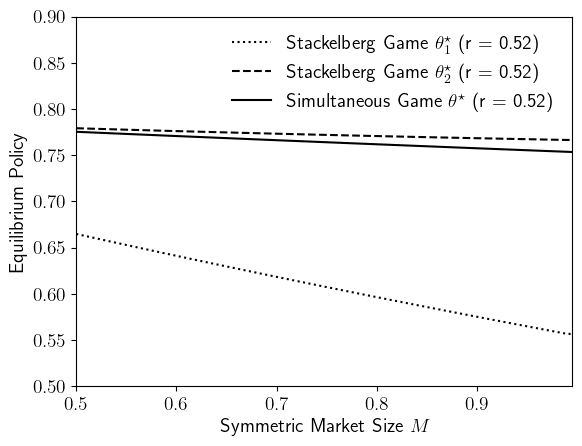

In [8]:
#
r_big = 0.52
gamma = 0.2

arr_M = []

arr_theta1_star = []
arr_theta2_star = []
arr_d1_star = []
arr_d2_star = []
arr_Phi1_star = []
arr_Phi2_star = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.5 + ii / 200
	# define game
	game_M = gm.Game2(n=5, r=r_big, M1=M, M2=M, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_star, theta2_star = theta_stars
		d1_star, d2_star = game.equilibrium(theta1_star, theta2_star)
		Pi1_star = government_obj(game.r, d1_star, d2_star, theta1_star, theta2_star, gamma)
		Pi2_star = government_obj(game.r, d2_star, d1_star, theta2_star, theta1_star, gamma)
		arr_theta1_star.append(theta1_star)
		arr_theta2_star.append(theta2_star)
		arr_d1_star.append(d1_star)
		arr_d2_star.append(d2_star)
		arr_Phi1_star.append(Pi1_star)
		arr_Phi2_star.append(Pi2_star)
	else:
		arr_theta1_star.append(None)
		arr_theta2_star.append(None)
		arr_d1_star.append(None)
		arr_d2_star.append(None)
		arr_Phi1_star.append(None)
		arr_Phi2_star.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.ylim((0.5, 0.9))
plt.xlabel(r'Symmetric Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='dotted',
	color='black',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='black',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_star)   ,
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta^\star$ (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_symcmp_policies_r52.pdf', bbox_inches='tight')
plt.show()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.ylim((0.16, 0.23))
plt.xlabel(r'Symmetric Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='dotted',
	color='black',
	label=f'Stackelberg Game Payoff of 1st Mover (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='black',
	label=f'Stackelberg Game Payoff of 2nd Mover (r = {r_big:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_star)   ,
	linestyle='solid',
	color='black',
	label=f'Simultaneous Game Symmetric Payoff (r = {r_big:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_symcmp_payoffs_r52.pdf', bbox_inches='tight')
plt.show()

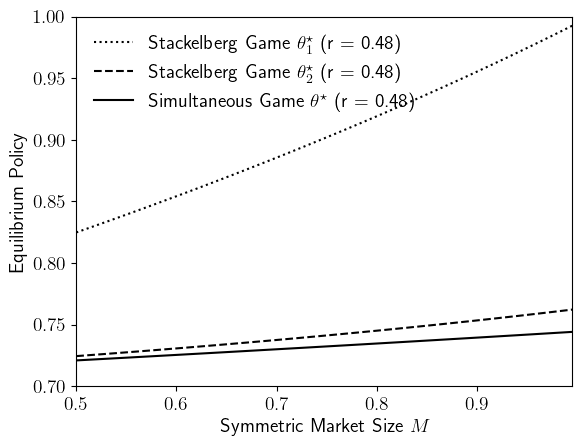

In [9]:
#
r_small = 0.48
gamma = 0.2

arr_M = []

arr_theta1_star = []
arr_theta2_star = []
arr_d1_star = []
arr_d2_star = []
arr_Phi1_star = []
arr_Phi2_star = []

arr_theta1_stackel = []
arr_theta2_stackel = []
arr_d1_stackel = []
arr_d2_stackel = []
arr_Phi1_stackel = []
arr_Phi2_stackel = []

for ii in range(100):
	M = 0.5 + ii / 200
	# define game
	game_M = gm.Game2(n=5, r=r_small, M1=M, M2=M, sigma1=1, sigma2=1)
	arr_M.append(M)
	# simultaneous policy
	theta_stars = simultaneous_eq(game_M, gamma, gamma)
	# stackelberg policy
	theta_stackel = stackelberg_eq(game_M, gamma, gamma)

	if theta_stars is not None:
		theta1_star, theta2_star = theta_stars
		d1_star, d2_star = game.equilibrium(theta1_star, theta2_star)
		Pi1_star = government_obj(game.r, d1_star, d2_star, theta1_star, theta2_star, gamma)
		Pi2_star = government_obj(game.r, d2_star, d1_star, theta2_star, theta1_star, gamma)
		arr_theta1_star.append(theta1_star)
		arr_theta2_star.append(theta2_star)
		arr_d1_star.append(d1_star)
		arr_d2_star.append(d2_star)
		arr_Phi1_star.append(Pi1_star)
		arr_Phi2_star.append(Pi2_star)
	else:
		arr_theta1_star.append(None)
		arr_theta2_star.append(None)
		arr_d1_star.append(None)
		arr_d2_star.append(None)
		arr_Phi1_star.append(None)
		arr_Phi2_star.append(None)
	if theta_stackel is not None:
		theta1_stackel, theta2_stackel = theta_stackel
		d1_stackel, d2_stackel = game.equilibrium(theta1_stackel, theta2_stackel)
		Pi1_stackel = government_obj(game.r, d1_stackel, d2_stackel, theta1_stackel, theta2_stackel, gamma)
		Pi2_stackel = government_obj(game.r, d2_stackel, d1_stackel, theta2_stackel, theta1_stackel, gamma)
		arr_theta1_stackel.append(theta1_stackel)
		arr_theta2_stackel.append(theta2_stackel)
		arr_d1_stackel.append(d1_stackel)
		arr_d2_stackel.append(d2_stackel)
		arr_Phi1_stackel.append(Pi1_stackel)
		arr_Phi2_stackel.append(Pi2_stackel)
	else:
		arr_theta1_stackel.append(None)
		arr_theta2_stackel.append(None)
		arr_d1_stackel.append(None)
		arr_d2_stackel.append(None)
		arr_Phi1_stackel.append(None)
		arr_Phi2_stackel.append(None)
	clear_output()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.ylim((0.7, 1.00))
plt.xlabel(r'Symmetric Market Size $M$')
plt.ylabel('Equilibrium Policy')
plt.plot(arr_M, filter_data(arr_theta1_stackel),
	linestyle='dotted',
	color='black',
	label=fr'Stackelberg Game $\theta_1^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta2_stackel),
	linestyle='dashed',
	color='black',
	label=fr'Stackelberg Game $\theta_2^\star$ (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_theta1_star)   ,
	linestyle='solid',
	color='black',
	label=fr'Simultaneous Game $\theta^\star$ (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_symcmp_policies_r48.pdf', bbox_inches='tight')
plt.show()

#
plt.xlim((arr_M[0], arr_M[-1]))
plt.ylim((0.19, 0.27))
plt.xlabel(r'Symmetric Market Size $M$')
plt.ylabel('Equilibrium Payoff')
plt.plot(arr_M, filter_data(arr_Phi1_stackel),
	linestyle='dotted',
	color='black',
	label=f'Stackelberg Game Payoff of 1st Mover (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi2_stackel),
	linestyle='dashed',
	color='black',
	label=f'Stackelberg Game Payoff of 2nd Mover (r = {r_small:.2f})')
plt.plot(arr_M, filter_data(arr_Phi1_star)   ,
	linestyle='solid',
	color='black',
	label=f'Simultaneous Game Symmetric Payoff (r = {r_small:.2f})')
plt.legend(frameon=False, loc='best')
plt.savefig('../_numerical_output/fig_symcmp_payoffs_r48.pdf', bbox_inches='tight')
plt.show()